## Import general libraries

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [47]:
def show_correlation(df, size=(15,10)):
    corr = df.corr()
    fig, ax = plt.subplots()
    fig.set_size_inches(size[0], size[1])
    sns.heatmap(corr, annot=True)

In [48]:
# test = pd.read_csv("../input/titanic/test.csv")
# train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

In [49]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Encode Sex and Cabin column and fill missing Ages with negative numbers

In [50]:
print('Train')
print(train.isnull().sum())
print('==========================')
print('Test')
print(test.isnull().sum())

Train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [51]:

train = train.fillna({'Age': -0.1})
test = test.fillna({'Age': -0.1})

#encode sex
sex_encoder = LabelEncoder()
sex_encoder.fit(['male', 'female'])
train['Sex'] = sex_encoder.transform(train['Sex'])
test['Sex'] = sex_encoder.transform(test['Sex'])


#encode cabin
train.loc[~train.Cabin.isnull(), 'Cabin'] = 1
train.loc[train.Cabin.isnull(), 'Cabin'] = 0

test.loc[~test.Cabin.isnull(), 'Cabin'] = 1
test.loc[test.Cabin.isnull(), 'Cabin'] = 0

#fill missed 'Embarked' values with max embarked places

#encode embarked feature
embarked_encoder = LabelEncoder()

#detect wich is a most common embarking place
common_embarked = train.groupby(['Embarked'])['Embarked'].value_counts().idxmax()[0]
train = train.fillna({'Embarked': common_embarked})
test = test.fillna({'Embarked': common_embarked})

# fill 'Fare' null values in test
test.loc[test.Fare.isnull(), 'Fare'] = 0

In [52]:
print('Train')
print(train.isnull().sum())
print('Test')
print(test.isnull().sum())

Train
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64
Test
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


## Creating new column 'Title' derived from 'Name'

In [53]:
train['Title'] = train.Name.str.split(',', n=1, expand=True)[1].str.split('.',n=1, expand=True)[0]
train['Title'] = train.Title.str.strip()
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr


In [54]:
test['Title'] = test.Name.str.split(',', n=1, expand=True)[1].str.split('.', n=1, expand=True)[0]
test['Title'] = test.Title.str.strip()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,Q,Mr
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,S,Mrs


## Group Titles ('Mr', 'Miss', 'Mrs', 'Master', 'Other')

In [55]:
train.loc[train.Title == 'Ms', 'Title'] = 'Miss'
test.loc[test.Title == 'Ms', 'Title'] = 'Miss'

train.loc[~train.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'
test.loc[~test.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'

## Encode grouped Titles

In [56]:
train['FareGroup'] = pd.cut(train.Fare, [-0.1, 30, 70, 100, np.inf], labels=['very cheap', 'cheap', 'normal', 'expensive'])
test['FareGroup']= pd.cut(test.Fare, [-0.1, 30, 70, 100, np.inf], labels=['very cheap', 'cheap', 'normal', 'expensive'])

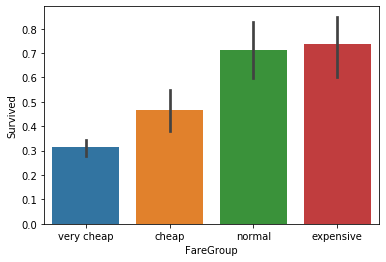

In [13]:
sns.barplot(x='FareGroup', y='Survived', data=train)

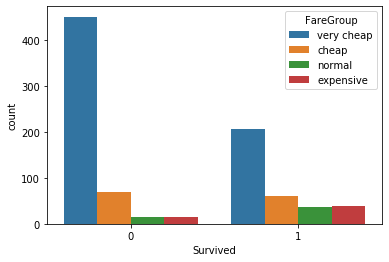

In [57]:
sns.countplot(x='Survived', hue='FareGroup', data=train)

In [58]:
fare_dummies = pd.get_dummies(train.FareGroup)[['normal', 'expensive']]
fare_dummies.columns = ['NormalTicket', 'ExpensiveTicket']
train = train.join(fare_dummies)
train.drop(['FareGroup'], axis=1, inplace=True)

fare_dummies = pd.get_dummies(test.FareGroup)[['normal', 'expensive']]
fare_dummies.columns = ['NormalTicket', 'ExpensiveTicket']
test = test.join(fare_dummies)
test.drop(['FareGroup'], axis=1, inplace=True)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,NormalTicket,ExpensiveTicket
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr,0,0


In [59]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,NormalTicket,ExpensiveTicket
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,Q,Mr,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,S,Mrs,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,Q,Mr,0,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,S,Mr,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,S,Mrs,0,0


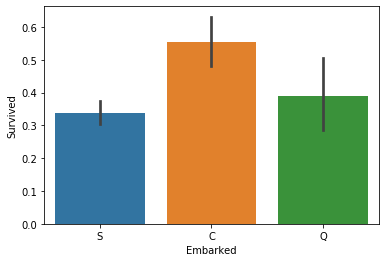

In [60]:
sns.barplot(x='Embarked', y='Survived', data=train)

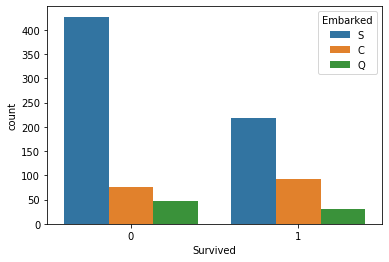

In [61]:
sns.countplot(x='Survived', hue='Embarked', data=train)

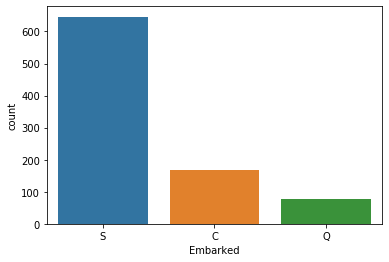

In [62]:
sns.countplot(train.Embarked)

In [63]:
# embarked_dummies = pd.get_dummies(train.Embarked)[['C']]
# train = train.join(embarked_dummies)
# train.drop(['Embarked'], axis=1, inplace=True)

# embarked_dummies = pd.get_dummies(test.Embarked)[['C']]
# test = test.join(embarked_dummies)
# test.drop(['Embarked'], axis=1, inplace=True)

# train.head()

train.drop(['Embarked'], axis=1, inplace=True)
test.drop(['Embarked'], axis=1, inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,Mr,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,Miss,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,Mrs,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,Mr,0,0


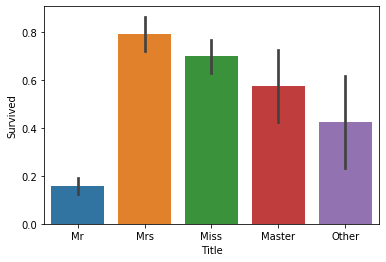

In [64]:
sns.barplot(x='Title', y='Survived', data=train)

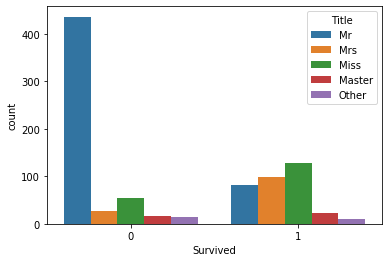

In [65]:
sns.countplot(x='Survived', hue='Title', data=train)

In [66]:
# train.loc[(train.Title == 'Mrs') | (train.Title == 'Miss'), 'Title'] = 'MrsMiss'
# test.loc[(test.Title == 'Mrs') | (test.Title == 'Miss'), 'Title'] = 'MrsMiss'
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,Mr,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,Miss,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,Mrs,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,Mr,0,0


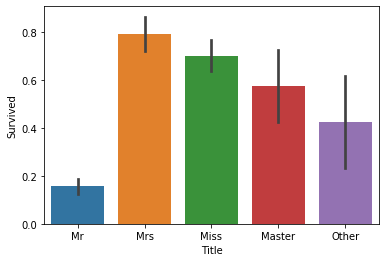

In [67]:
sns.barplot(x='Title', y='Survived', data=train)

In [68]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,Mr,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,Miss,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,Mrs,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,Mr,0,0


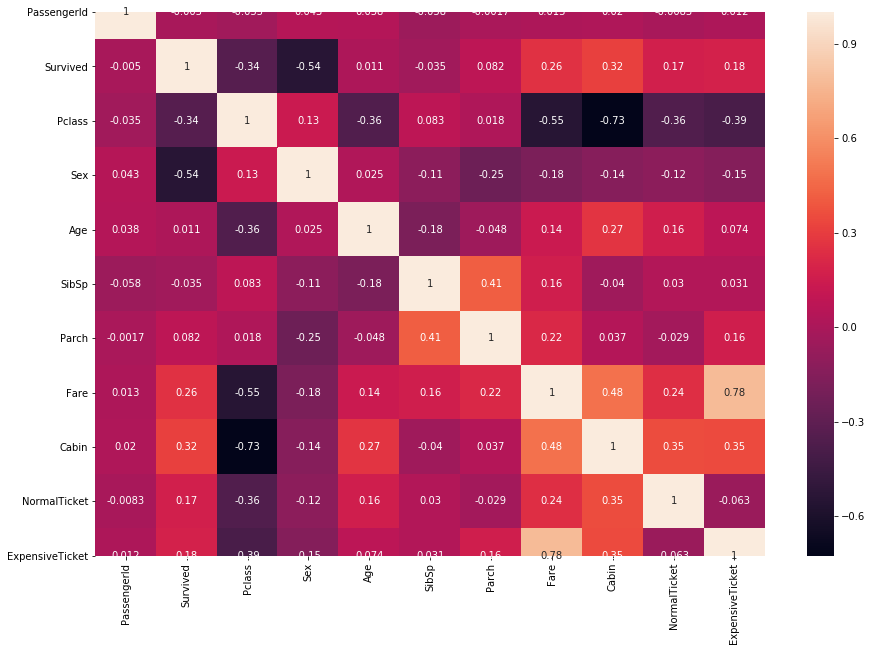

In [69]:
show_correlation(train)

In [71]:
# title_dummies = pd.get_dummies(train.Title)[['MrsMiss', 'Master']]
# title_dummies.head()
# train = train.join(title_dummies)
# #train.drop(['Title'], axis=1, inplace=True)

# title_dummies = pd.get_dummies(test.Title)[['MrsMiss', 'Master']]
# test = test.join(title_dummies)
# #test.drop(['Title'], axis=1, inplace=True)



train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,Mr,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,Miss,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,Mrs,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,Mr,0,0


In [72]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,Mr,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,Miss,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,Mrs,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,Mr,0,0


In [73]:
train['Alone'] = ((train.Parch + train.SibSp) == 0).astype(int)
test['Alone'] = ((test.Parch + test.SibSp) == 0).astype(int)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,Mr,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,Mrs,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,Miss,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,Mrs,0,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,Mr,0,0,1


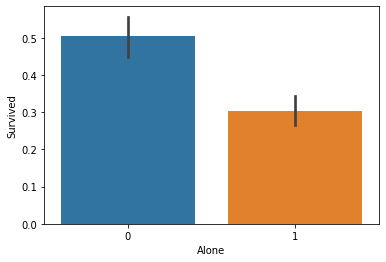

In [74]:
sns.barplot(x='Alone', y='Survived', data=train)

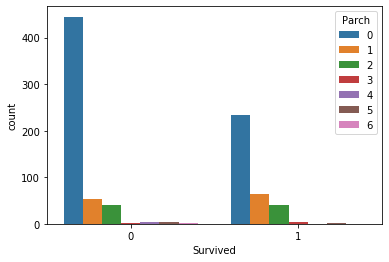

In [75]:
sns.countplot(x='Survived', hue='Parch', data=train)

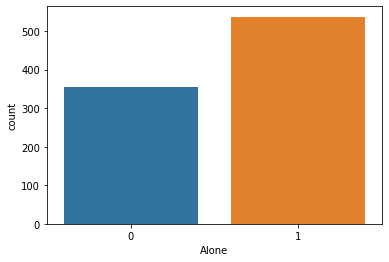

In [76]:
sns.countplot(train.Alone)

In [77]:
train = train.drop(['Name', 'SibSp', 'Parch'], axis=1)
test = test.drop(['Name', 'SibSp', 'Parch'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone
0,1,0,3,1,22.0,A/5 21171,7.2500,0,Mr,0,0,0
1,2,1,1,0,38.0,PC 17599,71.2833,1,Mrs,1,0,0
2,3,1,3,0,26.0,STON/O2. 3101282,7.9250,0,Miss,0,0,1
3,4,1,1,0,35.0,113803,53.1000,1,Mrs,0,0,0
4,5,0,3,1,35.0,373450,8.0500,0,Mr,0,0,1


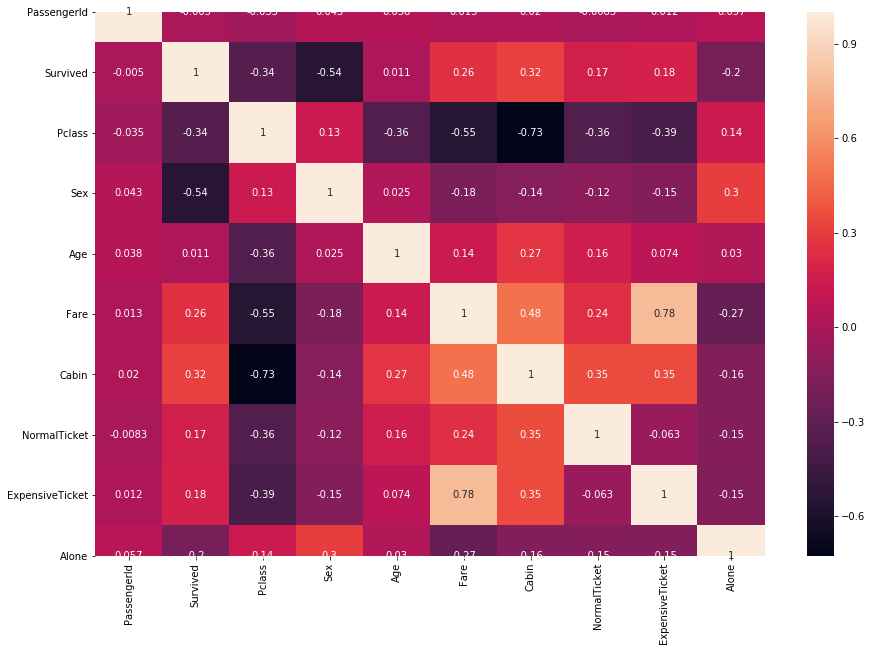

In [78]:
show_correlation(train)

In [683]:
# remove MrsMiss feature because it is high correlated with 'Sex' feature
# train.drop(['MrsMiss'], axis=1, inplace=True)
# test.drop(['MrsMiss'], axis=1, inplace=True)


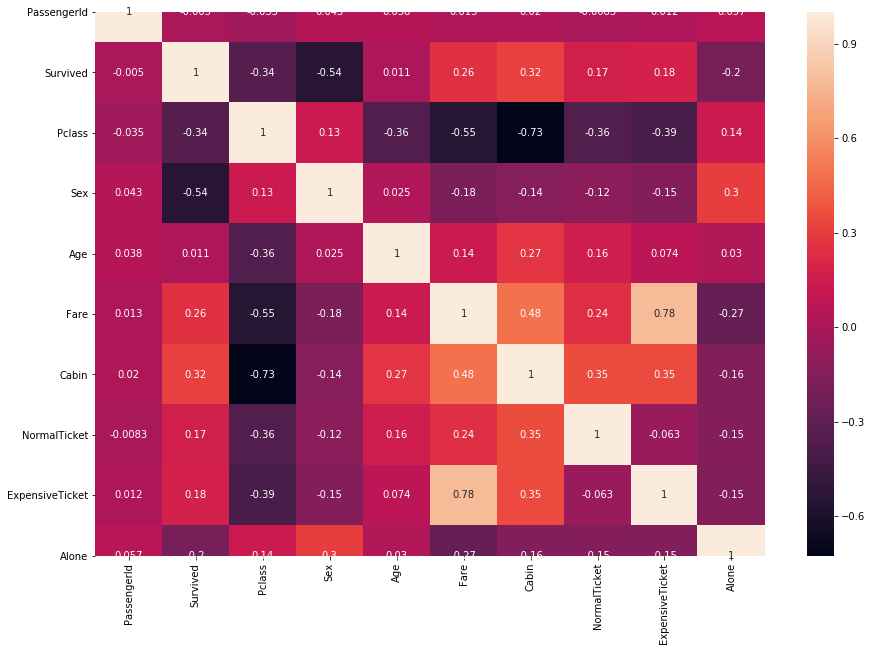

In [79]:
show_correlation(train)

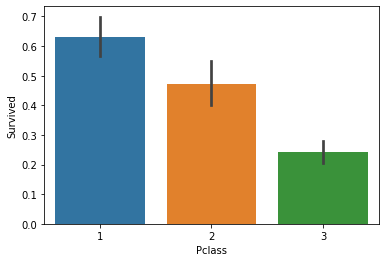

In [80]:
sns.barplot(x='Pclass', y='Survived', data=train)

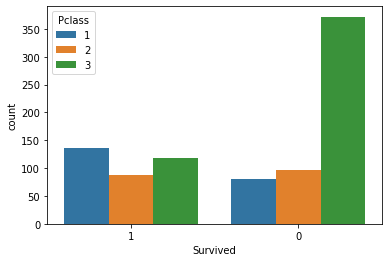

In [81]:
sns.countplot(x='Survived', hue="Pclass", data=train, order=[1,0])

In [82]:
class_dummies = pd.get_dummies(train.Pclass)
class_dummies.columns = ['Class1', 'Class2', 'Class3']
class_dummies.drop(['Class3', 'Class2'], axis=1, inplace=True)

train = train.join(class_dummies)
train.drop(['Pclass'], axis=1, inplace=True)

class_dummies = pd.get_dummies(test.Pclass)
class_dummies.columns = ['Class1', 'Class2', 'Class3']
class_dummies.drop(['Class3', 'Class2'], axis=1, inplace=True)

test = test.join(class_dummies)
test.drop(['Pclass'], axis=1, inplace=True)

train.head()


,PassengerId,Survived,Sex,Age,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone,Class1
0,1,0,1,22.0,A/5 21171,7.2500,0,Mr,0,0,0,0
1,2,1,0,38.0,PC 17599,71.2833,1,Mrs,1,0,0,1
2,3,1,0,26.0,STON/O2. 3101282,7.9250,0,Miss,0,0,1,0
3,4,1,0,35.0,113803,53.1000,1,Mrs,0,0,0,1
4,5,0,1,35.0,373450,8.0500,0,Mr,0,0,1,0


In [44]:
train.head()

,PassengerId,Survived,Sex,Age,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Master,Alone,Class1
0,1,0,1,22.0,A/5 21171,7.2500,0,Mr,0,0,0,0,0
1,2,1,0,38.0,PC 17599,71.2833,1,MrsMiss,1,0,0,0,1
2,3,1,0,26.0,STON/O2. 3101282,7.9250,0,MrsMiss,0,0,0,1,0
3,4,1,0,35.0,113803,53.1000,1,MrsMiss,0,0,0,0,1
4,5,0,1,35.0,373450,8.0500,0,Mr,0,0,0,1,0


In [83]:
# train.drop(['Title'], axis=1, inplace=True)
# test.drop(['Title'], axis=1, inplace=True)
train.head()

,PassengerId,Survived,Sex,Age,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone,Class1
0,1,0,1,22.0,A/5 21171,7.2500,0,Mr,0,0,0,0
1,2,1,0,38.0,PC 17599,71.2833,1,Mrs,1,0,0,1
2,3,1,0,26.0,STON/O2. 3101282,7.9250,0,Miss,0,0,1,0
3,4,1,0,35.0,113803,53.1000,1,Mrs,0,0,0,1
4,5,0,1,35.0,373450,8.0500,0,Mr,0,0,1,0


In [89]:
def encode_title(t):
    encoder = {
        'Mr': 1,
        'Mrs': 2,
        'Miss': 3,
        'Master': 4,
        'Other': 5
    }
    
    return encoder.get(t, 0)

train.Title = train.Title.apply(encode_title)
test.Title = test.Title.apply(encode_title)
train.head()

,PassengerId,Survived,Sex,Age,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone,Class1
0,1,0,1,22.0,A/5 21171,7.2500,0,1,0,0,0,0
1,2,1,0,38.0,PC 17599,71.2833,1,2,1,0,0,1
2,3,1,0,26.0,STON/O2. 3101282,7.9250,0,3,0,0,1,0
3,4,1,0,35.0,113803,53.1000,1,2,0,0,0,1
4,5,0,1,35.0,373450,8.0500,0,1,0,0,1,0


## Unite train and test data to predict missing 'Age'-s

In [96]:
df = pd.concat([train, test])
df.isnull().sum()

Age                  0
Alone                0
Cabin                0
Class1               0
ExpensiveTicket      0
Fare                 0
NormalTicket         0
PassengerId          0
Sex                  0
Survived           418
Ticket               0
Title                0
dtype: int64

## Remove unnecessary columns for predicting missing 'Age' values

In [97]:
df = df.drop(['PassengerId', 'Survived'], axis=1)
df.head()

,Age,Alone,Cabin,Class1,ExpensiveTicket,Fare,NormalTicket,Sex,Ticket,Title
0,22.0,0,0,0,0,7.2500,0,1,A/5 21171,1
1,38.0,0,1,1,0,71.2833,1,0,PC 17599,2
2,26.0,1,0,0,0,7.9250,0,0,STON/O2. 3101282,3
3,35.0,0,1,1,0,53.1000,0,0,113803,2
4,35.0,1,0,0,0,8.0500,0,1,373450,1


## Check out correlation matrix as heatmap

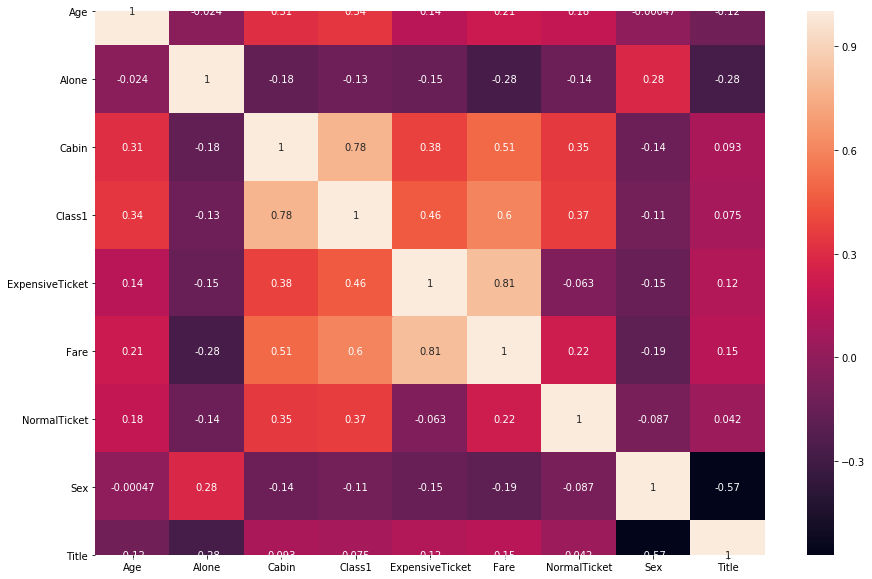

In [92]:
show_correlation(df)

## Prepare predictors and targets

In [98]:
predictors = df[df.Age > 0].drop(['Age', 'Ticket'], axis=1)
targets = df[df.Age > 0]['Age']

predictors.head()

,Alone,Cabin,Class1,ExpensiveTicket,Fare,NormalTicket,Sex,Title
0,0,0,0,0,7.2500,0,1,1
1,0,1,1,0,71.2833,1,0,2
2,1,0,0,0,7.9250,0,0,3
3,0,1,1,0,53.1000,0,0,2
4,1,0,0,0,8.0500,0,1,1


In [99]:
test.isnull().sum()

PassengerId        0
Sex                0
Age                0
Ticket             0
Fare               0
Cabin              0
Title              0
NormalTicket       0
ExpensiveTicket    0
Alone              0
Class1             0
dtype: int64

In [100]:
scaler = StandardScaler()
predictors = scaler.fit_transform(predictors)

In [101]:
#split data into train and test
x_train, x_test, y_train, y_test = train_test_split(predictors, targets, test_size = 0.22, random_state = 0)


## Predict ages using Multi Layer Perceptron

In [102]:
mlp = MLPRegressor(hidden_layer_sizes=(143, ))
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
mean_squared_error(y_pred, y_test), mean_squared_error(mlp.predict(x_train), y_train), mlp

(113.7375705146813,
 143.94234187979546,
 MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(143,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False))

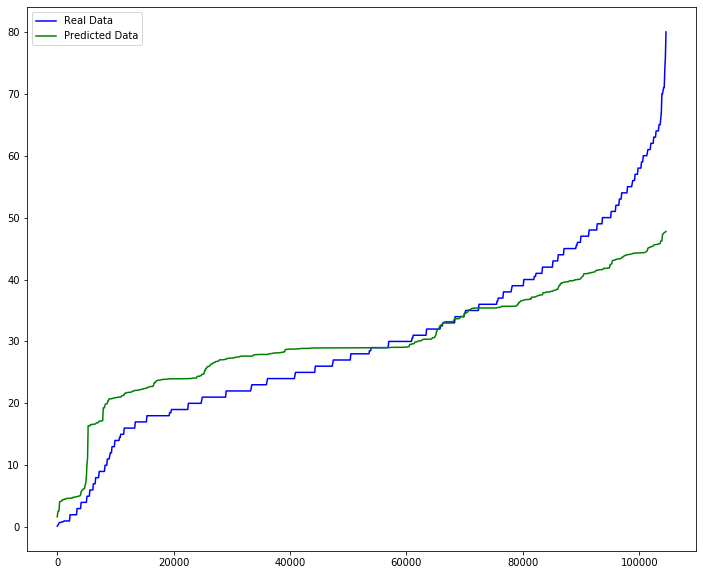

In [697]:
real_data = np.sort(np.concatenate((y_train, y_test)))
predicted_data = np.sort(np.concatenate((mlp.predict(x_train), mlp.predict(x_test))))

fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

plt.plot(np.linspace(start=0, stop=len(real_data)*100, num=len(real_data)), real_data, color='b', label='Real Data')
plt.plot(np.linspace(start=0, stop=len(real_data)*100, num=len(real_data)), predicted_data, color='g', label='Predicted Data')

plt.legend()

In [103]:
df[df.Age > 0].drop(['Age'], axis=1).head()

,Alone,Cabin,Class1,ExpensiveTicket,Fare,NormalTicket,Sex,Ticket,Title
0,0,0,0,0,7.2500,0,1,A/5 21171,1
1,0,1,1,0,71.2833,1,0,PC 17599,2
2,1,0,0,0,7.9250,0,0,STON/O2. 3101282,3
3,0,1,1,0,53.1000,0,0,113803,2
4,1,0,0,0,8.0500,0,1,373450,1


In [104]:
train.loc[train.Age < 0, 'Age'] = mlp.predict(scaler.transform(train[train['Age'] < 0][['Alone', 'Cabin', 'Class1', 'ExpensiveTicket', 'Fare',  'NormalTicket', 'Sex', 'Title']]))
test.loc[test.Age < 0, 'Age'] = mlp.predict(scaler.transform(test[test['Age'] < 0][['Alone', 'Cabin', 'Class1', 'ExpensiveTicket', 'Fare',  'NormalTicket', 'Sex', 'Title']]))

## Show age distribution

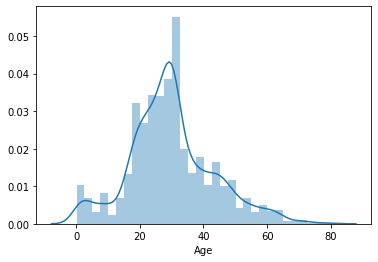

In [105]:
sns.distplot(pd.concat([train, test])['Age'])

In [106]:
pd.concat([train, test]).head()


,Age,Alone,Cabin,Class1,ExpensiveTicket,Fare,NormalTicket,PassengerId,Sex,Survived,Ticket,Title
0,22.0,0,0,0,0,7.2500,0,1,1,0.0,A/5 21171,1
1,38.0,0,1,1,0,71.2833,1,2,0,1.0,PC 17599,2
2,26.0,1,0,0,0,7.9250,0,3,0,1.0,STON/O2. 3101282,3
3,35.0,0,1,1,0,53.1000,0,4,0,1.0,113803,2
4,35.0,1,0,0,0,8.0500,0,5,1,0.0,373450,1


In [107]:
train['AgeGroup'] = pd.cut(train.Age, [0, 16, 21, 40, 60, np.inf], labels=[0, 1, 2, 3, 4])
test['AgeGroup'] = pd.cut(test.Age, [0, 16, 21, 40, 60, np.inf], labels=[0, 1, 2, 3, 4])
train.head()

,PassengerId,Survived,Sex,Age,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone,Class1,AgeGroup
0,1,0,1,22.0,A/5 21171,7.2500,0,1,0,0,0,0,2
1,2,1,0,38.0,PC 17599,71.2833,1,2,1,0,0,1,2
2,3,1,0,26.0,STON/O2. 3101282,7.9250,0,3,0,0,1,0,2
3,4,1,0,35.0,113803,53.1000,1,2,0,0,0,1,2
4,5,0,1,35.0,373450,8.0500,0,1,0,0,1,0,2


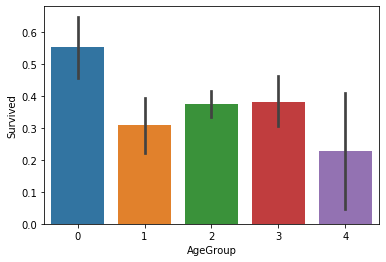

In [108]:
sns.barplot(x='AgeGroup', y='Survived', data=train)

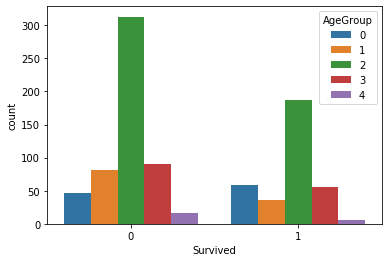

In [109]:
sns.countplot(x='Survived', hue="AgeGroup", data=train)

In [110]:
agegroup_dummies = pd.get_dummies(train['AgeGroup'])[[0]]
agegroup_dummies.columns = ['Child']
train = train.join(agegroup_dummies)

agegroup_dummies = pd.get_dummies(test['AgeGroup'])[[0]]
agegroup_dummies.columns = ['Child']
test = test.join(agegroup_dummies)

train.head()



,PassengerId,Survived,Sex,Age,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone,Class1,AgeGroup,Child
0,1,0,1,22.0,A/5 21171,7.2500,0,1,0,0,0,0,2,0
1,2,1,0,38.0,PC 17599,71.2833,1,2,1,0,0,1,2,0
2,3,1,0,26.0,STON/O2. 3101282,7.9250,0,3,0,0,1,0,2,0
3,4,1,0,35.0,113803,53.1000,1,2,0,0,0,1,2,0
4,5,0,1,35.0,373450,8.0500,0,1,0,0,1,0,2,0


In [111]:
train.drop(['AgeGroup'], axis=1, inplace=True)
test.drop(['AgeGroup'], axis=1, inplace=True)

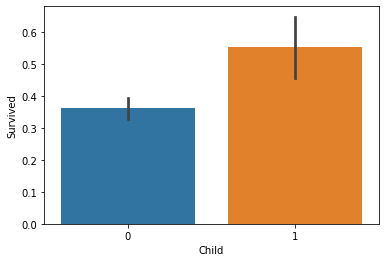

In [112]:
sns.barplot(x='Child', y='Survived', data=train)

In [113]:
train['TicketPrefix'] = train.Ticket.str.split(' ').apply(lambda x: x[0] if len(x) > 1 else 'No')
test['TicketPrefix'] = test.Ticket.str.split(' ').apply(lambda x: x[0] if len(x) > 1 else 'No')
train.head()

,PassengerId,Survived,Sex,Age,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone,Class1,Child,TicketPrefix
0,1,0,1,22.0,A/5 21171,7.2500,0,1,0,0,0,0,0,A/5
1,2,1,0,38.0,PC 17599,71.2833,1,2,1,0,0,1,0,PC
2,3,1,0,26.0,STON/O2. 3101282,7.9250,0,3,0,0,1,0,0,STON/O2.
3,4,1,0,35.0,113803,53.1000,1,2,0,0,0,1,0,No
4,5,0,1,35.0,373450,8.0500,0,1,0,0,1,0,0,No


In [114]:
train.groupby(['TicketPrefix'])['TicketPrefix'].count()

TicketPrefix
A./5.           2
A.5.            2
A/4             3
A/4.            3
A/5            10
A/5.            7
A/S             1
A4.             1
C               5
C.A.           27
C.A./SOTON      1
CA              6
CA.             8
F.C.            1
F.C.C.          5
Fa              1
No            665
P/PP            2
PC             60
PP              3
S.C./A.4.       1
S.C./PARIS      2
S.O./P.P.       3
S.O.C.          5
S.O.P.          1
S.P.            1
S.W./PP         1
SC              1
SC/AH           3
SC/PARIS        5
SC/Paris        4
SCO/W           1
SO/C            1
SOTON/O.Q.      8
SOTON/O2        2
SOTON/OQ        7
STON/O         12
STON/O2.        6
SW/PP           1
W./C.           9
W.E.P.          1
W/C             1
WE/P            2
Name: TicketPrefix, dtype: int64

In [115]:
train.loc[train.TicketPrefix.str.startswith('A'), 'TicketPrefix'] = 'A'
train.loc[train.TicketPrefix.str.startswith('C'), 'TicketPrefix'] = 'C'
train.loc[train.TicketPrefix.str.startswith('F'), 'TicketPrefix'] = 'F'
train.loc[train.TicketPrefix.str.startswith('P'), 'TicketPrefix'] = 'P'
train.loc[train.TicketPrefix.str.startswith('S'), 'TicketPrefix'] = 'S'
train.loc[train.TicketPrefix.str.startswith('W'), 'TicketPrefix'] = 'W'

test.loc[test.TicketPrefix.str.startswith('A'), 'TicketPrefix'] = 'A'
test.loc[test.TicketPrefix.str.startswith('C'), 'TicketPrefix'] = 'C'
test.loc[test.TicketPrefix.str.startswith('F'), 'TicketPrefix'] = 'F'
test.loc[test.TicketPrefix.str.startswith('P'), 'TicketPrefix'] = 'P'
test.loc[test.TicketPrefix.str.startswith('S'), 'TicketPrefix'] = 'S'
test.loc[test.TicketPrefix.str.startswith('W'), 'TicketPrefix'] = 'W'

train.groupby(['TicketPrefix'])['TicketPrefix'].count()


TicketPrefix
A      29
C      47
F       7
No    665
P      65
S      65
W      13
Name: TicketPrefix, dtype: int64

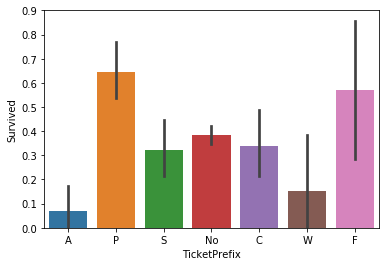

In [116]:
sns.barplot(x='TicketPrefix', y='Survived', data=train)

In [117]:
ticket_dummies = pd.get_dummies(train.TicketPrefix)[['P', 'F']]
ticket_dummies.columns = ['Ticket_P', 'Ticket_F']
train = train.join(ticket_dummies)

ticket_dummies = pd.get_dummies(train.TicketPrefix)[['P', 'F']]
ticket_dummies.columns = ['Ticket_P', 'Ticket_F']
test = test.join(ticket_dummies)

train.head()

,PassengerId,Survived,Sex,Age,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone,Class1,Child,TicketPrefix,Ticket_P,Ticket_F
0,1,0,1,22.0,A/5 21171,7.2500,0,1,0,0,0,0,0,A,0,0
1,2,1,0,38.0,PC 17599,71.2833,1,2,1,0,0,1,0,P,1,0
2,3,1,0,26.0,STON/O2. 3101282,7.9250,0,3,0,0,1,0,0,S,0,0
3,4,1,0,35.0,113803,53.1000,1,2,0,0,0,1,0,No,0,0
4,5,0,1,35.0,373450,8.0500,0,1,0,0,1,0,0,No,0,0


In [118]:
train.drop(['Ticket', 'TicketPrefix'], axis=1, inplace=True)
test.drop(['Ticket', 'TicketPrefix'], axis=1, inplace=True)

In [119]:
train.head()

,PassengerId,Survived,Sex,Age,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone,Class1,Child,Ticket_P,Ticket_F
0,1,0,1,22.0,7.2500,0,1,0,0,0,0,0,0,0
1,2,1,0,38.0,71.2833,1,2,1,0,0,1,0,1,0
2,3,1,0,26.0,7.9250,0,3,0,0,1,0,0,0,0
3,4,1,0,35.0,53.1000,1,2,0,0,0,1,0,0,0
4,5,0,1,35.0,8.0500,0,1,0,0,1,0,0,0,0


## Prepare predictors and targets for final prediction

In [120]:
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
predictors = StandardScaler().fit_transform(predictors)
targets = train[['Survived']]

In [121]:
x_train, x_test, y_train, y_test = train_test_split(predictors, targets, test_size = 0.22, random_state = 0)


## Try different classifiers

In [122]:
classifiers = {
    'KNN': KNeighborsClassifier(3),
    'SVC Linear': SVC(kernel="linear", C=0.025),
    'SVC': SVC(gamma=2, C=1),
    'Gaussian': GaussianProcessClassifier(1.0 * RBF(1.0)),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RandomForest': RandomForestClassifier(),
    'MLP': MLPClassifier(alpha=1, max_iter=1000),
    'AdaBoost': AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis()
}

In [125]:
for name, classifier in classifiers.items():
    classifier.fit(x_train, y_train)
    
    
    y_pred = classifier.predict(x_train)
    test_pred = classifier.predict(x_test)
    
    score = accuracy_score(y_train, y_pred)
    test_score = accuracy_score(y_test, test_pred)
    print('{}- original score: {};  test score: {}; average: {};'.format(name, score, test_score, np.mean([score, test_score])))

KNN- original score: 0.8688760806916427;  test score: 0.7461928934010152; average: 0.807534487046329;
SVC Linear- original score: 0.7838616714697406;  test score: 0.7969543147208121; average: 0.7904079930952763;
SVC- original score: 0.8602305475504323;  test score: 0.7766497461928934; average: 0.8184401468716629;
Gaussian- original score: 0.7982708933717579;  test score: 0.7918781725888325; average: 0.7950745329802953;
DecisionTree- original score: 0.8342939481268011;  test score: 0.7918781725888325; average: 0.8130860603578168;
RandomForest- original score: 0.9798270893371758;  test score: 0.8020304568527918; average: 0.8909287730949838;
MLP- original score: 0.80835734870317;  test score: 0.8071065989847716; average: 0.8077319738439708;
AdaBoost- original score: 0.8342939481268011;  test score: 0.8324873096446701; average: 0.8333906288857356;
GaussianNB- original score: 0.7175792507204611;  test score: 0.7258883248730964; average: 0.7217337877967788;
QuadraticDiscriminantAnalysis- ori

## Choose Gaussian classifier for final prediction

In [135]:
model = classifiers['AdaBoost']


In [133]:
test.drop(['PassengerId'], axis=1).head()

,Sex,Age,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,Alone,Class1,Child,Ticket_P,Ticket_F
0,1,34.5,7.8292,0,1,0,0,1,0,0,0,0
1,0,47.0,7.0000,0,2,0,0,0,0,0,1,0
2,1,62.0,9.6875,0,1,0,0,1,0,0,0,0
3,1,27.0,8.6625,0,1,0,0,1,0,0,0,0
4,0,22.0,12.2875,0,2,0,0,0,0,0,0,0


In [136]:
ids = test['PassengerId']
predictions = model.predict(StandardScaler().fit_transform(test.drop(['PassengerId'], axis=1)))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('adasubmission.csv', index=False)